Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Model Interpretation 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [x] Make at least 1 partial dependence plot to explain your model.
- [x] Share at least 1 visualization on Slack.

If you have not yet completed an initial model yet for your portfolio project, you can do today's assignment using your Tanzania Waterpumps model. An example solution will be provided.

**Multi-class classification** will result in multiple Partial Dependence Plots (one for each class).

## Stretch Goals
- [x] Make multiple PDPs with 1 feature in isolation.
- [x] Make multiple PDPs with 2 features in interaction. 
- [x] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('train_features-Copy1.csv'), 
                 pd.read_csv('train_labels-Copy1.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('test_features-Copy1.csv')
sample_submission = pd.read_csv('sample_submission-Copy1.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], 
                              random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [2]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val   = val[features]
y_val   = val[target]
X_test  = test[features]

In [3]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact

In [4]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(cols=['basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type']),
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(),
    SelectKBest(f_classif, k=20),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9940867003367003
Validation Accuracy 0.7787878787878788


In [5]:
X_val.select_dtypes(include='number').dtypes

amount_tsh           float64
gps_height           float64
longitude            float64
latitude             float64
num_private            int64
region_code            int64
district_code          int64
population           float64
construction_year    float64
year_recorded          int64
month_recorded         int64
day_recorded           int64
years                float64
dtype: object

CPU times: user 1min 18s, sys: 637 ms, total: 1min 19s
Wall time: 1min 16s


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x122b1ab38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1232317b8>})

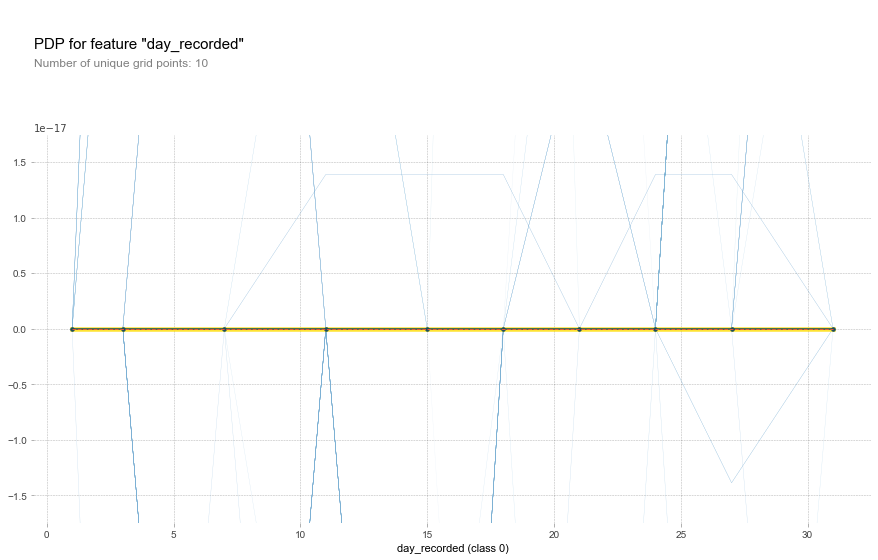

In [6]:
%%time

feature='day_recorded'           # int64

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

pdp_plot(isolated, 
         feature_name=feature, 
         which_classes=[0], 
         plot_lines=True, 
         x_quantile=False)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x124ac9c50>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x145653780>})

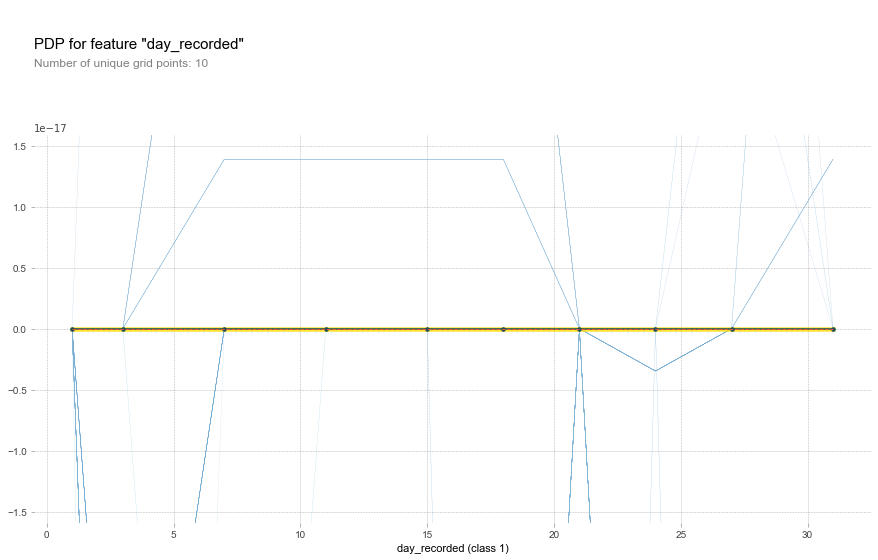

In [29]:
pdp_plot(isolated, 
         feature_name=feature, 
         which_classes=[1], 
         plot_lines=True, 
         x_quantile=False)

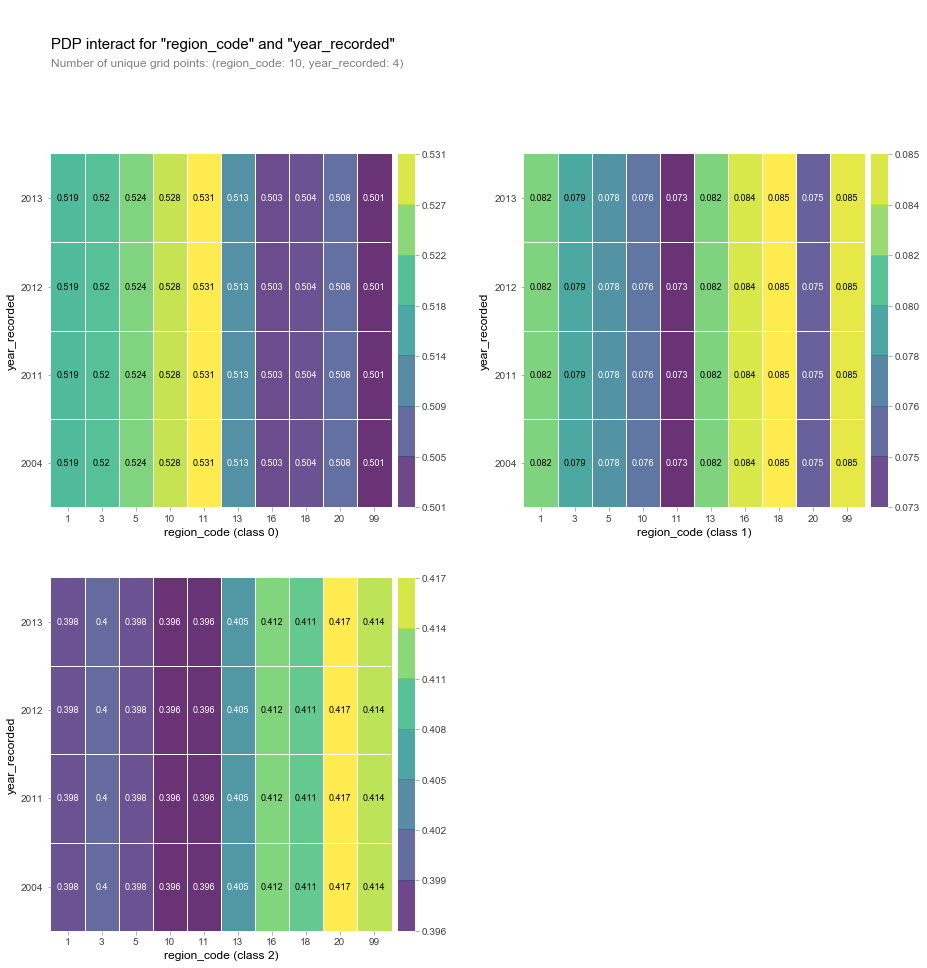

In [7]:
rf = pdp.pdp_interact(model=pipeline,
                                dataset=X_val,
                                model_features=X_val.columns,
                                features=['region_code', 'year_recorded'],
                                num_grid_points=[10, 10],
                                percentile_ranges=[None, None],
                                n_jobs=-1
                               )
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=rf,
                                  feature_names=['region_code', 'year_recorded'],
                                  plot_type='grid',
                                  x_quantile=True,
                                  ncols=2,
                                  plot_pdp=False,
                                 )

### Stretch Goal - Use Plotly to make a 3D PDP.

In [10]:
example = X_val.iloc[[0]]
example2 = X_val.iloc[[2]]
examples = pd.concat([example, example2])

examples['district_code'] = 7
preds = pipeline.predict(examples)
preds

array(['non functional', 'functional'], dtype=object)

In [12]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox.pdp import pdp_isolate, pdp_plot

features=['region_code','num_private']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

# pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [27]:
interaction

In [28]:
y_val.value_counts()

functional                 6452
non functional             4565
functional needs repair     863
Name: status_group, dtype: int64

In [23]:
pdp = interaction[0].pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]    
    )[::-1]  

from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns,
    y=pdp.index,
    z=pdp.values
)

fig = go.Figure(surface)
fig.show()

In [24]:
pdp1 = interaction[1].pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]    
    )[::-1]  

from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go

surface1 = go.Surface(
    x=pdp1.columns,
    y=pdp1.index,
    z=pdp1.values
)

fig = go.Figure(surface1)
fig.show()

In [26]:
pdp2 = interaction[2].pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]    
    )[::-1]  

from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go

surface2 = go.Surface(
    x=pdp2.columns,
    y=pdp2.index,
    z=pdp2.values
)

fig = go.Figure(surface2)
fig.show()